# NLP test

In [201]:
import sqlite3
import matplotlib.pyplot as plt
import pickle
import janome
import sklearn
import numpy as np
import pandas as pd
import collections
import sqlite3
import re
% matplotlib inline

In [14]:
# DB保存
conn = sqlite3.connect('reviews.sqlite3')
cur = conn.cursor()

cur.execute("select content from spams")
obj = cur.fetchall()

conn.commit()
conn.close()

In [24]:
# 形態素解析Mecab + neologd版
import MeCab

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

# art="080-3322-9382に電話かけてください"
res = []
for art in obj:
    art = art[0]
    mecab.parse("")
    res.append((len(mecab.parse(art).split())-1)/2)

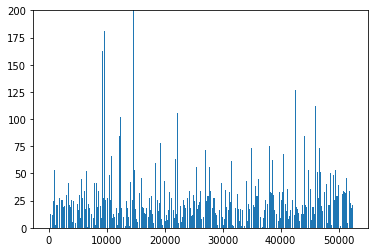

In [29]:
plt.figure()
plt.bar(np.arange(len(res)),res)
plt.ylim(0,200)
plt.show()

In [31]:
print(np.mean(np.array(res)),np.std(np.array(res)),np.min(np.array(res)),np.max(np.array(res)))

31.1362605747 38.4226533099 0.0 1410.0


In [30]:
whitelist = "\n「」。、あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゐゆゑよらりるれろわをんがぎぐげござじずぜぞだぢづでどばびぶべぼぱぴぷぺぽぁぃぅぇぉゃゅょっゎ"
whitelist = set(whitelist)

In [203]:
'''
形態素解析Mecab + neologd版
all_dataはsentenceごとのひらがな分かち書き
whitelistの単語のみ許容
sentece末尾に終端文字を入れる
'''

import MeCab
import jaconv

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')   #for mac
# mecab = MeCab.Tagger ('-d /usr/lib/mecab/dic/mecab-ipadic-neologd') # for ubuntu

sentence_num = 10000

all_data = []
for art in obj[:sentence_num]:
    art = art[0]
    
    mecab.parse("")    
    node = mecab.parseToNode(art)
    
    tmp_data = []
    while node:
        #単語を取得
        word = node.surface
        #品詞を取得
        pos = node.feature.split(",")

        # 記号とwhitelist以外の単語を弾く
        if pos[0] != '記号':
            word = jaconv.kata2hira(pos[-2])
            if (set(word) - whitelist) == set():
                tmp_data.append(jaconv.kata2hira(pos[-2]))
            
        #次の単語に進める
        node = node.next
        
    # 終端文字挿入
    tmp_data.append("E")
    
    all_data.append(tmp_data)

In [204]:
all_data

[['とうとう',
  'みんしん',
  'は',
  'たてまえ',
  'さえ',
  'も',
  'ほうかい',
  'し',
  'た',
  'の',
  'か',
  'じぶん',
  'の',
  'かんがえ',
  'に',
  'じしん',
  'が',
  'もて',
  'ない',
  'とう',
  'に',
  'めいしょう',
  'かえろ',
  'よ',
  'E'],
 ['じえいたい', 'ぐんたい', 'みとめ', 'て', 'よい', 'はやく', 'みとめよ', 'う', 'E'],
 ['がいじん',
  'なんて',
  'もの',
  'が',
  'そんざい',
  'する',
  'みん',
  'しんとう',
  'が',
  'あんぜんほしょう',
  'かたっ',
  'て',
  'はずかしく',
  'ない',
  'の',
  'か',
  'よ',
  'E'],
 ['まだ', 'みたい', 'な', 'こと', 'いっ', 'て', 'て', 'びっくり', 'だ', 'わ', 'E'],
 ['おんけんほしゅ',
  'わろた',
  'おまえ',
  'ら',
  'みんきょう',
  'がったい',
  'の',
  'きょくさせいとう',
  'だろ',
  'う',
  'が',
  'みんきょう',
  'がったい',
  'で',
  'とくあ',
  'だ',
  'E'],
 ['いま',
  'まで',
  'みんしんとう',
  'が',
  'どういう',
  'かぜ',
  'に',
  'しゅちょう',
  'し',
  'て',
  'こっかい',
  'を',
  'くうてん',
  'さ',
  'せ',
  'て',
  'き',
  'た',
  'か',
  'わすれ',
  'た',
  'の',
  'ぶれ',
  'てる',
  'どころ',
  'の',
  'はなし',
  'じゃ',
  'ない',
  'ばっち',
  'を',
  'つけ',
  'たい',
  'だけ',
  'の',
  'ぎいん',
  'なんか',
  'いら',
  'ねぇ',
  'E'],
 ['いま',
  'の',
  'しじしゃ',
  'が',
  

In [205]:
'''
全単語の辞書とword2vec作成
'''

all_word = []
for s in all_data:
    all_word.extend(s)
    
# 全単語ベクトル
word_id_dict = {k:v for v,k in enumerate(list(set(all_word)))}
id_word_dict = {k:v for v,k in word_id_dict.items()}
word_num = len(word_id_dict)

with open("corpus.txt","w") as f:
    for i in all_word:
        f.write(i+" ")

# word2vec
from gensim.models import word2vec

sentences = word2vec.Text8Corpus('corpus.txt')

word_model = word2vec.Word2Vec(sentences,
                          sg=1,
                          size=200,
                          min_count=1,
                          window=10,
                          hs=1,
                          negative=0)


In [207]:
# sentenceごと，trigramのx_dataと次の単語のy_data生成

x_data = []
y_data = []
for s in all_data:
    s_len = len(s)
    if s_len < 4:
        continue
    trigram = []
    next_word = []
    for i in range(s_len - 4):
        trigram.append(s[i:i+3])
        next_word.append(word_id_dict[s[i+3]])
    x_data.extend([[word_model[y] for y in x] for x in trigram])
    y_data.extend(next_word)
x_data = np.array(x_data)
y_data = np.array(y_data)

In [208]:
print(np.array(x_data).shape)
print(np.array(y_data).shape)
print(len(word_id_dict))

(213337, 3, 200)
(213337,)
14609


In [211]:
# one hot vectorize

# x_train = x_data[:10000].reshape(10000,3,1)
# y_train = y_data[:10000]
# x_test = x_data[10000:12000].reshape(2000,3,1)
# y_test = y_data[10000:12000]

x_train = np.array(x_data)

y_train = y_data

from keras.utils import np_utils

nb_classes = len(word_id_dict)

# x_train = np_utils.to_categorical(y_train, nb_classes)
# x_test = np_utils.to_categorical(y_test, nb_classes)

Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

print("x_train shape:",x_train.shape)
print("Y_train shape:",Y_train.shape)

x_train shape: (213337, 3, 200)
Y_train shape: (213337, 14609)


In [218]:
# LSTM model

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(128, batch_input_shape=(1,3,200), stateful=True))
model.add(Dense(word_num))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (1, 128)                  168448    
_________________________________________________________________
dense_12 (Dense)             (1, 14609)                1884561   
_________________________________________________________________
activation_12 (Activation)   (1, 14609)                0         
Total params: 2,053,009
Trainable params: 2,053,009
Non-trainable params: 0
_________________________________________________________________


In [220]:
x_train.shape

(213337, 3, 200)

In [200]:
history = model.fit(x_train, Y_train, batch_size=1, epochs=3, shuffle=False)

Epoch 1/3
88604/88604 [==============================] - 130s - loss: 9.8213 - acc: 0.1025   
Epoch 2/3
88604/88604 [==============================] - 126s - loss: 8.6870 - acc: 0.1203   
Epoch 3/3
88604/88604 [==============================] - 126s - loss: 8.4267 - acc: 0.1374   


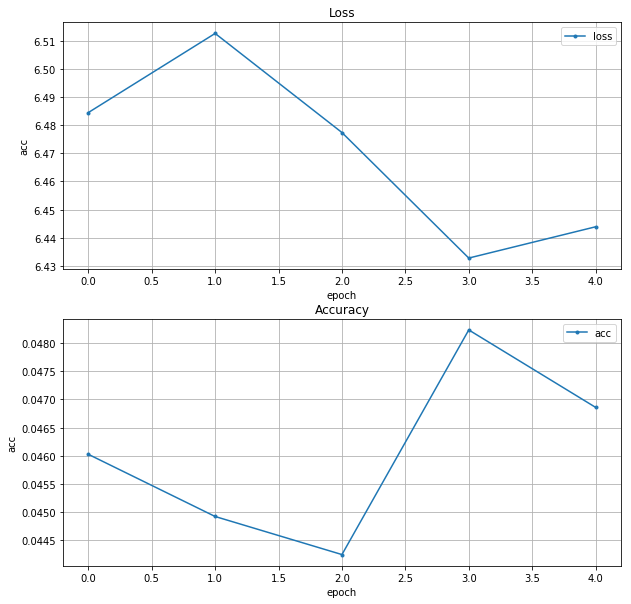

In [147]:
# 学習の様子をプロット
loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history.history['acc']
# val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
# plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
# plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()